## Creating a Baseline using MLPs

This script will walk you through the creating of a baseline model for the data. You will have to make some choices of hyper-parameteres so you can either search for those values manually or using a gridsearch... No need to use HyperBand for this simple problem =)

In [10]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import importlib
import fncs_helper
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
from torchsummary import summary
import os

importlib.reload(fncs_helper)

import json
with open('Settings.json') as f:
    S = json.load(f)
    dataFolder = S['dataFolder']

### Loading the Data and Features

First, we define a helper function to load the data and compute the features. Take a look at how the labels are extracted by following a similar procedure for window extraction and assigning the mode.

Extracting the features for the training data and splitting it into training / validation.

In [3]:
# Specifying the data directory
dirTrain = dataFolder + 'Train/'

# Specifying some parameters for the feature extraction
timeStep = 1
winSz = 2

# Specifying IDs for training and validation sets
valIDs = [2,11,25]
trainIDs = list(set(np.array(range(25))+1).difference(valIDs))

# Recovering the features and labels
xTrain, yTrain = fncs_helper.loadFeatures(dirTrain,winSz,timeStep,trainIDs)
xVal, yVal = fncs_helper.loadFeatures(dirTrain,winSz,timeStep,valIDs)

# Saving validation set
np.savetxt('Data/val.x.csv',xVal,delimiter=',')
np.savetxt('Data/val.y.csv',yVal,fmt='%d')

### Training MLPs

Our main objective will be to do some optimization on the architecture. Let us begin by defining some constant parameters.

In [14]:
# Defining the input and output size of the model
INPUTSIZE = 12
OUTPUTSIZE = 4

# Specify the device that you will use here.

# This works if you are just using your local machine with no GPU
DEVICE = 'cpu'

# This works if youare using the Jupyter Hub
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# DEVICE = torch.device("cuda:0")

#### 1-Layer MLP

Our first MLP model is a single layer model. In this case, we don't have a choice on the number of neurons since the dimensions of the layer are pre-determined by the input and ouput.

We begin by defining the neural network class.

In [34]:
# Defining the neural network architecture
class Net1(nn.Module):
  def __init__(self):
    super(Net1, self).__init__()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(INPUTSIZE,OUTPUTSIZE)
    )
  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

Defining and training a model. We are providing some default values for the number of epochs and the weights. You need to find a better set of values so you overcome the low balanced accuracy results.

In [108]:
# Reloading the settings in case you end up modifying them
with open('Settings.json') as f:
    S = json.load(f)
    
# Number of epochs specified in the settings file
epochs = S['1Layer']['epochs']

# The weights for cross-entropy specified in the settings file
weights = S['1Layer']['weights']

In [109]:
importlib.reload(fncs_helper)

# Defining the Model
model = Net1().to(DEVICE)
M1 = fncs_helper.NetWrapper(model,DEVICE,epochs,weights)

# Displaying a summary
summary(M1.model,(1,INPUTSIZE))

# Training the model
M1.fit(xTrain,yTrain)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1, 4]              52
Total params: 52
Trainable params: 52
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
[Epoch  1000 of 10000] loss: 0.748932
[Epoch  2000 of 10000] loss: 0.647218
[Epoch  3000 of 10000] loss: 0.614590
[Epoch  4000 of 10000] loss: 0.598964
[Epoch  5000 of 10000] loss: 0.590706
[Epoch  6000 of 10000] loss: 0.585625
[Epoch  7000 of 10000] loss: 0.581649
[Epoch  8000 of 10000] loss: 0.578149
[Epoch  9000 of 10000] loss: 0.575020
[Epoch 10000 of 10000] loss: 0.572226


Performance on training and validation sets.

RESULTS:

Training:  Acc = 0.812
Training:  BalAcc = 0.789
Validation: Acc = 0.824
Validation: BalAcc = 0.756


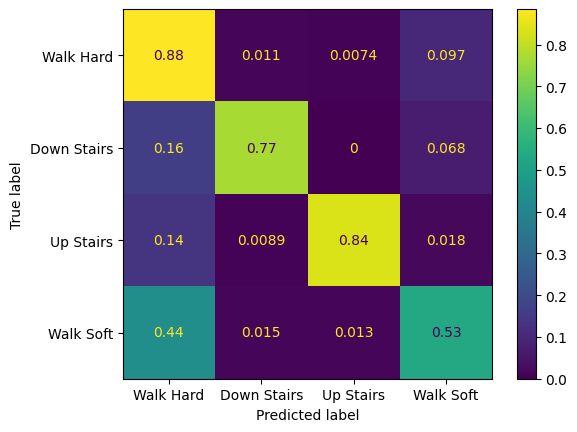

In [110]:
yTrainHat1 = M1.predict(xTrain)
yValHat1 = M1.predict(xVal)

print('RESULTS:\n')
fncs_helper.summaryPerf(yTrain,yTrainHat1,yVal,yValHat1)

# Saving the predictions since they will be used for testing later
np.savetxt('Data/1LayerPred.y.csv',yValHat1,fmt='%d')

# Saving the model
model_scripted = torch.jit.script(model)
model_scripted.save('Models/model_1Layer.pt')

**TASK:** Your task is to select the hyper-parameters specified in `Settings.json` for the 1-layer model so your performance exceeds 0.75 on balanced accuracy. Once you are done, can run the test below.

In [111]:
!python -m pytest fnc_1Layer_test.py

============================= test session starts =============================
platform win32 -- Python 3.12.1, pytest-8.3.4, pluggy-1.5.0
rootdir: c:\Users\Cody\Documents\ECE 492 Github\sp25-ML-Gait1-ThatCowch
collected 1 item

fnc_1Layer_test.py .                                                     [100%]

============================== 1 passed in 1.72s ==============================


#### 2-Layer MLP

In this case, we have a choice on the number of neurons for the hidden layer. Note that in this section, we will use the optimal number of epochs and weights found on the previous section.

In [113]:
# Defining the neural network architecture
class Net2(nn.Module):
  def __init__(self,noNeurons):
    super(Net2, self).__init__()
    self.linear_relu_stack = nn.Sequential(
        nn.Linear(INPUTSIZE,noNeurons),
        nn.ReLU(),
        nn.Linear(noNeurons,OUTPUTSIZE),
    )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

Defining and training the model with an arbitrary number of neurons.

In [171]:
# Reloading the settings in case you end up modifying them
with open('Settings.json') as f:
    S = json.load(f)
    
# Number of epochs specified in the settings file
epochs = S['2Layer']['epochs']

# The weights for cross-entropy specified in the settings file
weights = S['2Layer']['weights']

# The number of neurosn in the hiddne layers
noNeurons = S['2Layer']['noNeurons']

In [172]:
# Defining the Model
model = Net2(noNeurons).to(DEVICE)
M2 = fncs_helper.NetWrapper(model,DEVICE,epochs,weights)

# Displaying a summary
summary(M2.model,(1,INPUTSIZE))

# Training the model
M2.fit(xTrain,yTrain)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]             130
              ReLU-2                [-1, 1, 10]               0
            Linear-3                 [-1, 1, 4]              44
Total params: 174
Trainable params: 174
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
[Epoch  1000 of 12000] loss: 0.567685
[Epoch  2000 of 12000] loss: 0.506582
[Epoch  3000 of 12000] loss: 0.476429
[Epoch  4000 of 12000] loss: 0.452028
[Epoch  5000 of 12000] loss: 0.444146
[Epoch  6000 of 12000] loss: 0.430602
[Epoch  7000 of 12000] loss: 0.421641
[Epoch  8000 of 12000] loss: 0.418136
[Epoch  9000 of 12000] loss: 0.416284
[Epoch 10000 of 12000] loss:

Performance of predictions using the training and validation set.

RESULTS:

Training:  Acc = 0.830
Training:  BalAcc = 0.842
Validation: Acc = 0.808
Validation: BalAcc = 0.823


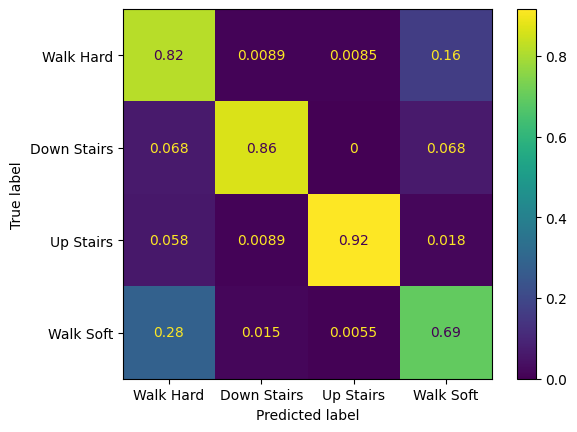

In [173]:
yTrainHat2 = M2.predict(xTrain)
yValHat2 = M2.predict(xVal)

print('RESULTS:\n')
fncs_helper.summaryPerf(yTrain,yTrainHat2,yVal,yValHat2)

# Saving the predictions since they will be used for testing later
np.savetxt('Data/2LayerPred.y.csv',yValHat2,fmt='%d')

# Saving the model
model_scripted = torch.jit.script(model)
model_scripted.save('Models/model_2Layer.pt')

**TASK:** Your task is to select the hyper-parameters specified in `Settings.json` for the 2-layer model so your performance exceeds 0.82 on balanced accuracy. Once you are done, can run the test below.

In [174]:
!python -m pytest fnc_2Layer_test.py

============================= test session starts =============================
platform win32 -- Python 3.12.1, pytest-8.3.4, pluggy-1.5.0
rootdir: c:\Users\Cody\Documents\ECE 492 Github\sp25-ML-Gait1-ThatCowch
collected 1 item

fnc_2Layer_test.py .                                                     [100%]

============================== 1 passed in 1.10s ==============================


#### 3-Layer MLP

When defining a 3-layer MLP, we have a choice for two of the neurons. We will set the first hidden layer to have the same number of layers as the optimal value found from the previous sections. We will also reuse the weights and number of epochs.

In this case, you will have to complete the neural network below to have an additional hidden layer followed by a ReLU activation.

In [ ]:
# Defining the neural network architecture
class Net3(nn.Module):
  def __init__(self,noNeurons1,noNeurons2):
    super(Net3, self).__init__()
    self.linear_relu_stack = nn.Sequential(
        ### BEGIN SOLUTION
        nn.Linear(INPUTSIZE,noNeurons1),
        nn.ReLU(),
        nn.Linear(noNeurons1,noNeurons2),
        nn.ReLU(),
        nn.Linear(noNeurons2,OUTPUTSIZE),
        ### END SOLUTION
    )

  def forward(self, x):
    logits = self.linear_relu_stack(x)
    return logits

In [ ]:
# Reloading the settings in case you end up modifying them
with open('Settings.json') as f:
    S = json.load(f)
    
# Number of epochs specified in the settings file
epochs = S['3Layer']['epochs']

# The weights for cross-entropy specified in the settings file
weights = S['3Layer']['weights']

# The number of neurosn in the hiddne layers
noNeurons1 = S['3Layer']['noNeurons1']
noNeurons2 = S['3Layer']['noNeurons2']

In [ ]:
# Defining the Model
model = Net3(noNeurons1,noNeurons2).to(DEVICE)
M3 = fncs_helper.NetWrapper(model,DEVICE,epochs,weights)

# Displaying a summary
summary(M3.model,(1,INPUTSIZE))

# Training the model
M3.fit(xTrain,yTrain)

Performance of predictions using the training and validation set.

In [ ]:
yTrainHat3 = M3.predict(xTrain)
yValHat3 = M3.predict(xVal)

print('RESULTS:\n')
fncs_helper.summaryPerf(yTrain,yTrainHat3,yVal,yValHat3)

# Saving the predictions since they will be used for testing later
np.savetxt('Data/3LayerPred.y.csv',yValHat3,fmt='%d')

# Saving the model
model_scripted = torch.jit.script(model)
model_scripted.save('Models/model_3Layer.pt')

**TASK:** Your task is to select the hyper-parameters specified in `Settings.json` for the 3-layer model so your performance exceeds 0.82 on balanced accuracy. Once you are done, can run the test below.

In [ ]:
!python -m pytest fnc_3Layer_test.py